## [Problem 1] Share and execute the official tutorial model

- we have used the time series forecasting using Recurrent Neural Networks (RNN), From the Tensoflow official tutorial models.
> https://www.tensorflow.org/tutorials/structured_data/time_series


In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [6]:
TRAIN_SPLIT = 300000

In [7]:
tf.random.set_seed(13)

- On the first PART the univariate time series is forecasted

In [8]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6622e882d0>],
      dtype=object)

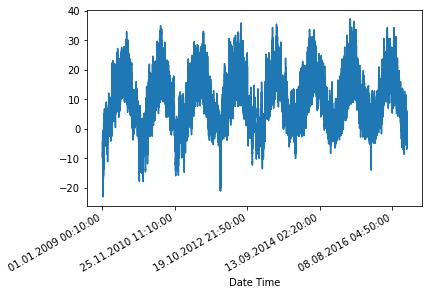

In [9]:
uni_data.plot(subplots=True)

- The above is how the data looks across time

In [10]:
uni_data = uni_data.values

In [11]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [12]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [13]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [14]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [15]:
def create_time_steps(length):
  return list(range(-length, 0))

In [16]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

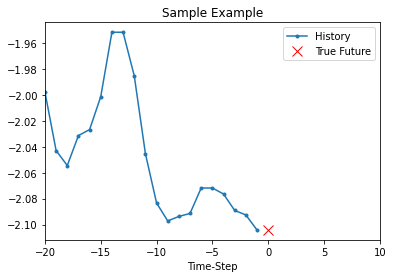

In [17]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [18]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

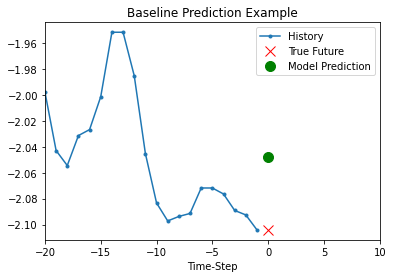

In [19]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Now the recurrent neural network comes into account

In [20]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [21]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [22]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [23]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 5s 16ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0263 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0253 - val_loss: 0.0181
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0227 - val_lo

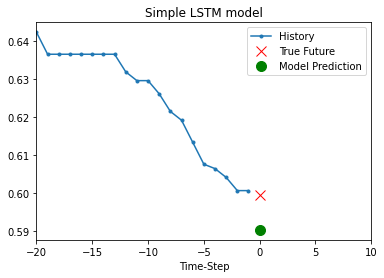

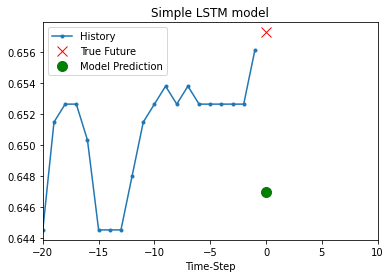

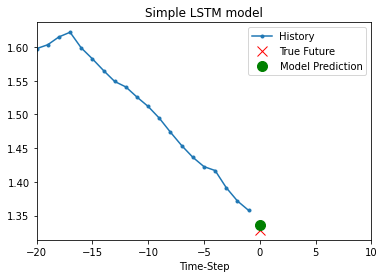

In [24]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

- The above part handled the univariable, let's now move to the multivariable forecasting

In [25]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [26]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f661ffc2290>,
      dtype=object)

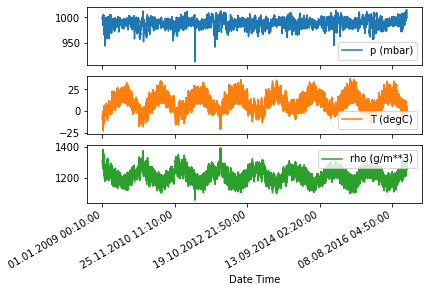

In [27]:
features.plot(subplots=True)

The above shows how each of the features vary across the time

In [28]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [29]:
dataset = (dataset-data_mean)/data_std

In [30]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [31]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [32]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [33]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [34]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [35]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [36]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 26s 119ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 23s 115ms/step - loss: 0.2623 - val_loss: 0.2421
Epoch 3/10
200/200 [==============================] - 23s 115ms/step - loss: 0.2611 - val_loss: 0.2448
Epoch 4/10
200/200 [==============================] - 23s 116ms/step - loss: 0.2568 - val_loss: 0.2447
Epoch 5/10
200/200 [==============================] - 23s 116ms/step - loss: 0.2260 - val_loss: 0.2368
Epoch 6/10
200/200 [==============================] - 23s 115ms/step - loss: 0.2415 - val_loss: 0.2658
Epoch 7/10
200/200 [==============================] - 23s 115ms/step - loss: 0.2413 - val_loss: 0.2565
Epoch 8/10
200/200 [==============================] - 23s 115ms/step - loss: 0.2406 - val_loss: 0.2381
Epoch 9/10
200/200 [==============================] - 23s 115ms/step - loss: 0.2451 - val_loss: 0.2480
Epoch 10/10
200/200 [==============================] - 23s 116ms/step - l

In [37]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

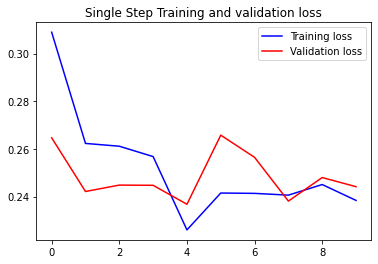

In [38]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

- Predicting a single step feature

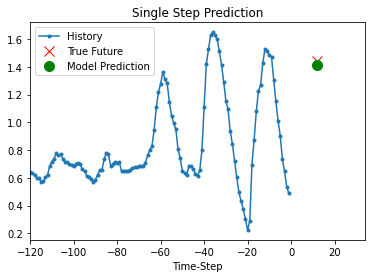

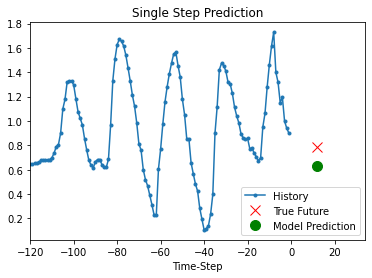

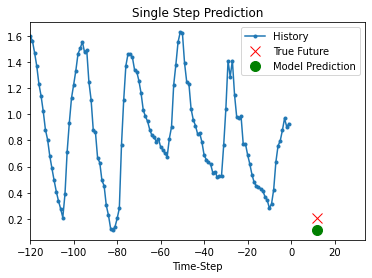

In [39]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

- Multi -Step model

In [40]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [41]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [42]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [43]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

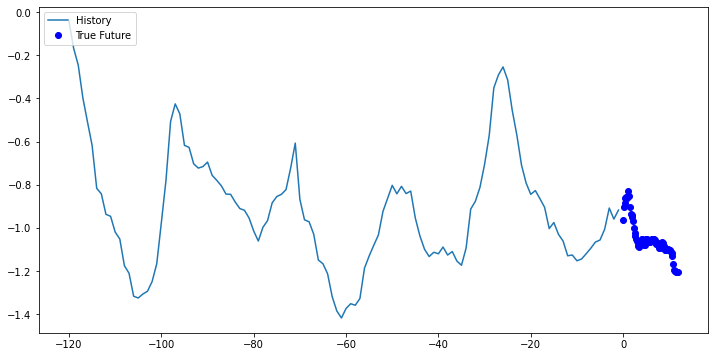

In [44]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [45]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [46]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [47]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 45s 207ms/step - loss: 0.4949 - val_loss: 0.3073
Epoch 2/10
200/200 [==============================] - 41s 204ms/step - loss: 0.3465 - val_loss: 0.2871
Epoch 3/10
200/200 [==============================] - 41s 204ms/step - loss: 0.3290 - val_loss: 0.2466
Epoch 4/10
200/200 [==============================] - 41s 207ms/step - loss: 0.2431 - val_loss: 0.2092
Epoch 5/10
200/200 [==============================] - 41s 203ms/step - loss: 0.1977 - val_loss: 0.1996
Epoch 6/10
200/200 [==============================] - 41s 203ms/step - loss: 0.2080 - val_loss: 0.2083
Epoch 7/10
200/200 [==============================] - 41s 204ms/step - loss: 0.1990 - val_loss: 0.2074
Epoch 8/10
200/200 [==============================] - 41s 203ms/step - loss: 0.1956 - val_loss: 0.1965
Epoch 9/10
200/200 [==============================] - 40s 202ms/step - loss: 0.1976 - val_loss: 0.1914
Epoch 10/10
200/200 [==============================] - 40s 203ms/step - l

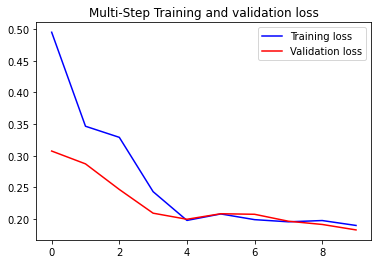

In [48]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

- Predicting a multi-step feature

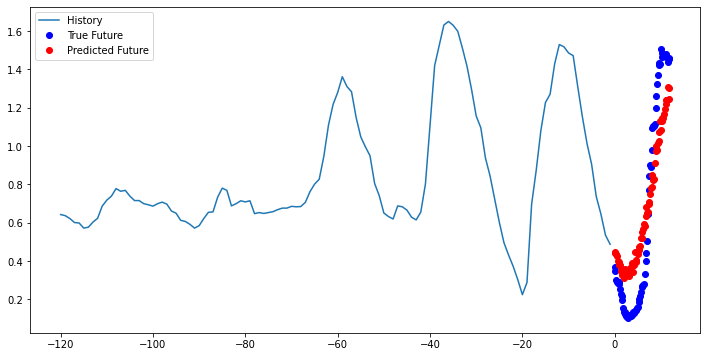

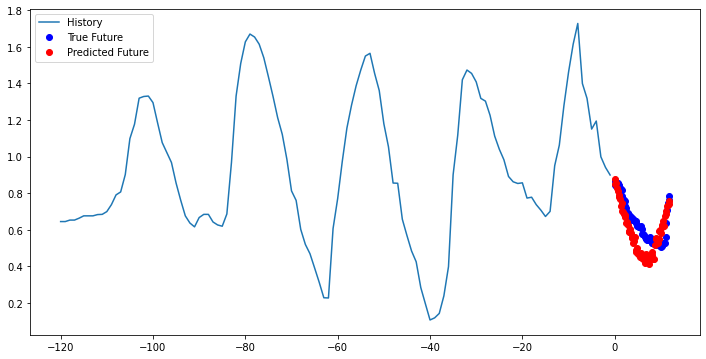

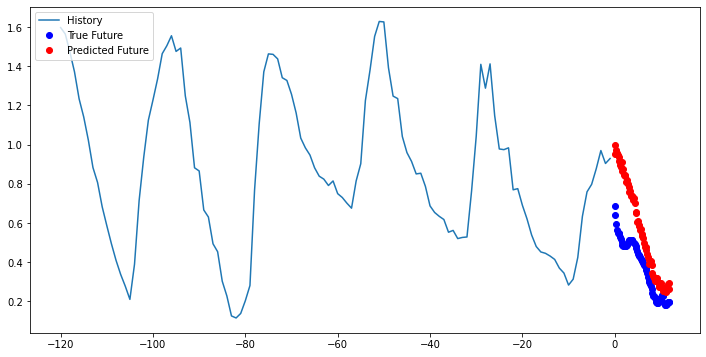

In [49]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

**Like we stated above, this was quick introduction to time series forecasting using an RNN**

## [Problem 3] Learn Iris (binary classification) with Keras

In [58]:
import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import adam_v2
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [59]:
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid))

In [60]:
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=10,
                    verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 33ms/step - loss: 0.8966 - accuracy: 0.6250 - val_loss: 0.5368 - val_accuracy: 0.6875
Epoch 2/10
7/7 [==============================] - 0s 7ms/step - loss: 0.5674 - accuracy: 0.6406 - val_loss: 0.5065 - val_accuracy: 0.6875
Epoch 3/10
7/7 [=========================

In [61]:
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

y_pred_proba [0.01097769 0.9774704  0.01012465 0.976468   0.7148932  0.9709039
 0.2191312  0.3935276  0.9812914  0.6601964  0.94300115 0.94566274
 0.9703265  0.08478534 0.00473741 0.00766084 0.25710338 0.00229406
 0.76826406 0.00509053]
y_pred [0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0]
y_test [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]


In [62]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.2029746025800705
Train accuracy: 0.8999999761581421


## [Problem 4] Learn Iris (multi-value classification) with Keras

In [66]:
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

In [67]:
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))

In [68]:
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
history = model.fit(X_train, y_train_one_hot,
                    batch_size=10,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val, y_val_one_hot))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 5,653
Trainable params: 5,653
Non-trainable params: 0
_________________________________________________________________


In [69]:
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

y_pred_proba [5.4093824e-10 4.7727861e-04 9.9994135e-01 3.7921102e-09 9.9918848e-01
 1.0828478e-11 9.9957997e-01 2.3122258e-04 9.6488067e-05 1.2277231e-03
 5.8397696e-08 5.3088012e-04 1.9676007e-04 1.4442240e-04 1.6532165e-04
 9.9829978e-01 2.5255169e-04 2.6816200e-04 9.9758756e-01 9.9985182e-01
 3.8825057e-08 2.4656474e-04 9.9712735e-01 9.9709404e-01 7.9772753e-06
 9.9987149e-01 9.9874926e-01 6.7972182e-04 5.3585302e-03 9.9841797e-01]
y_pred [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1]
y_test [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [70]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

y_pred [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]
y_test [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [71]:
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.03275114670395851
Train accuracy: 1.0


## [Problem 5] Learn House Prices with Keras

In [73]:
from sklearn.preprocessing import StandardScaler

train = pd.read_csv('train.csv')

x = train[['GrLivArea', 'YearBuilt']]
y = train[['SalePrice']]

x = np.log(x).values
y = np.log(y).values

sc = StandardScaler()
sc.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [74]:
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(2,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.keras.activations.linear))

In [75]:
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.compile(loss='mse',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['mse'])
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=20,
                    verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 4ms/step - loss: 3.8539 - mse: 3.8539 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 2/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0762 - mse: 0.0762 - val_loss: 0.1101 - val_mse: 0.1101
Epoch 3/20
94/94 [==============================] - 0s 3ms

In [76]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba
print("y_pred", y_pred.ravel()[:5])
print('y_test', y_test.ravel()[:5])

y_pred [12.535941 12.121205 11.886328 12.351567 11.808841]
y_test [12.20918779 11.79810441 11.60823564 12.16525065 11.38509209]


In [77]:
score = model.evaluate(X_test, y_test, verbose=0)
print('loss (test):', score[0])
print('Mean Squared Error (test):', score[1])

loss (test): 0.06990087777376175
Mean Squared Error (test): 0.06990087777376175


## [Problem 6] Learning MNIST with Keras

- Learning MNIST with Keras

In [78]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

11501568/11490434 [==============================] - 0s 0us/step


In [79]:
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(784,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))

In [80]:
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.005),
              metrics=['accuracy'])
history = model.fit(X_train, y_train_one_hot,
                    batch_size=20,
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val, y_val_one_hot))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 45,360
Trainable params: 45,360
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.2908 - accuracy: 0.9133 - val_loss: 0.1693 - val_accuracy: 0.9513
Epoch 2/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.1862 - accuracy: 0.9457 - val_loss: 0.2073 - val_accuracy: 0.9408
Epoch 3/5
2400/2400 [=========

In [81]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred[:10])
print('y_test', y_test.ravel()[:10])

y_pred [7 2 1 0 4 1 4 9 5 9]
y_test [7 2 1 0 4 1 4 9 5 9]


In [82]:
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16858190298080444
Test accuracy: 0.9585000276565552
